In [2]:
!git clone https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation.git
!pip install -q -r /content/Hybrid_Transformer_for_Portfolio_Allocation/requirements.txt

Cloning into 'Hybrid_Transformer_for_Portfolio_Allocation'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 117 (delta 49), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (117/117), 20.09 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (49/49), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 11.6 MB/s eta 0:00:00


In [ ]:
from runtime_test.eq_data_loader import get_eq_data
from runtime_test.data_prep_vanilla import vanilla_transformer_database
from runtime_test.benchmark_transformer_model import Transformer_Portfolio

import pandas as pd
import numpy as np
import tensorflow as tf
import json

In [ ]:
data_config = json.load(open('/content/runtime_test/data_config.json', 'r'))

In [ ]:
data = get_eq_data(
    '/content/runtime_test/nifty_50_metadata.csv',
    start = data_config['data_start_date'],
    end = data_config['data_end_date'],
    corr_thresh = data_config['correlation_thresh'],
    market_cap_filter = data_config['market_cap_filter']
)

[*********************100%%**********************]  50 of 50 completed


In [ ]:
xtrain, xtest, ytrain, ytest, train_index, test_index = vanilla_transformer_database(data = data, timestep = 16, lag = 5, lagSD = 5, test_size= 0.2, purge_size = 30)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1974, 16, 34) (501, 16, 34) (1974, 17) (501, 17)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from sklearn.model_selection import train_test_split
attention_numbers = [17, 34]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [4, 8, 16]
dropouts = [0.05, 0.1]

trainx, valx, trainy, valy = train_test_split(xtrain.numpy(), ytrain.numpy(), test_size = 0.2, shuffle = False)

model_performance = pd.DataFrame()

for an in attention_numbers:
    for lr in learning_rates:
        for bs in batch_sizes:
            for dp in dropouts:
                trainx = tf.convert_to_tensor(trainx[:int(trainx.shape[0] / bs) * bs, :, :], np.float32)
                trainy = tf.convert_to_tensor(trainy[:trainx.shape[0], :], np.float32)
                val_price = tf.convert_to_tensor(data.loc[train_index, :].iloc[:trainx.shape[0], :].pct_change().dropna().values, np.float32)

                tf.keras.utils.set_random_seed(42)
                tf.config.experimental.enable_op_determinism()

                model = Transformer_Portfolio(trainx.shape[1], trainx.shape[2], outputShape = trainy.shape[1],  headsAttention = an, dropout= dp, learningRate = lr, priceData = val_price, lb= 0, ub = 0.3)
                model.allocation_vanilla_train(trainx, trainy, Epochs = 10, BatchSize = bs)

                eval_price = data.iloc[-valx.shape[0]:, :]
                eval_weights = model.allocation_vanilla_test(valx)
                eval_mean = (eval_price * eval_weights).sum(axis = 1).pct_change().dropna().mean()
                eval_std = (eval_price * eval_weights).sum(axis = 1).pct_change().dropna().std()
                eval_sharpe = eval_mean / eval_std

                tf.keras.backend.clear_session()

                temp_performance = pd.DataFrame()
                temp_performance['attention_num'] = [an]
                temp_performance['learning_rate'] = [lr]
                temp_performance['batch_size'] = [bs]
                temp_performance['dropout'] = [dp]
                temp_performance['eval_sharpe_ratio'] = [eval_sharpe]

                model_performance = pd.concat([model_performance, temp_performance])

13/13 [==============================] - 1s 9ms/step


In [ ]:
model_performance.sort_values('eval_sharpe_ratio', ascending = False).head(1)

,attention_num,learning_rate,batch_size,dropout,eval_sharpe_ratio
0,34,0.0001,4,0.05,0.110725


In [ ]:
Dropout = 0.05
LearningRate = 0.0001
Epochs = 100
Alpha = 0.005
DF = 4
BatchSize = 4
lb = 0
ub = 0.3
num_heads = 34

xtrain = xtrain[:int(xtrain.shape[0] / BatchSize) * BatchSize, :, :]
ytrain = ytrain[:xtrain.shape[0], :]
priceData = tf.convert_to_tensor(data.loc[train_index, :].iloc[:xtrain.shape[0], :].pct_change().dropna().values, np.float32)

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()


model = Transformer_Portfolio(xtrain.shape[1], xtrain.shape[2], outputShape = ytrain.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate, priceData = priceData, lb= lb, ub = ub)
model.allocation_vanilla_train(xtrain, ytrain, Epochs = Epochs, BatchSize = BatchSize)

62/62 [==============================] - 1s 6ms/step


array([[0.01356793, 0.07915414, 0.07192739, ..., 0.05126237, 0.03555015,
        0.04451314],
       [0.01344548, 0.07848254, 0.07155821, ..., 0.05106718, 0.03627687,
        0.04482508],
       [0.01385554, 0.07844355, 0.07128771, ..., 0.05113319, 0.0377014 ,
        0.04582751],
       ...,
       [0.01517821, 0.0986972 , 0.05407651, ..., 0.05457378, 0.04168645,
        0.06588978],
       [0.0167291 , 0.09848461, 0.05318722, ..., 0.05691699, 0.0437957 ,
        0.06762035],
       [0.01718193, 0.098093  , 0.05352068, ..., 0.05736383, 0.04446027,
        0.0678056 ]], dtype=float32)

In [ ]:
test_weights = model.allocation_vanilla_test(xtest)

16/16 [==============================] - 0s 6ms/step


In [ ]:
test_weights

array([[0.01831268, 0.09154017, 0.04583437, ..., 0.05572814, 0.04589954,
        0.07274443],
       [0.01797401, 0.09205171, 0.04590464, ..., 0.05613503, 0.04570204,
        0.07340226],
       [0.01788136, 0.09212529, 0.04511577, ..., 0.05686793, 0.04546448,
        0.07419632],
       ...,
       [0.01780434, 0.06693806, 0.07418103, ..., 0.04249479, 0.04174709,
        0.05083207],
       [0.01747701, 0.0665163 , 0.07457607, ..., 0.04185105, 0.04143108,
        0.05018351],
       [0.01726752, 0.06662753, 0.07453188, ..., 0.04128254, 0.04138241,
        0.05002581]], dtype=float32)

In [ ]:
test_mean = ((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :].round(3)).sum(axis = 1) - 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).mean()
test_mean

0.0010379343536614243

In [ ]:
test_std = ((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :].round(3)).sum(axis = 1) - 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).std()
test_std

0.007067814812641186

In [ ]:
test_sharpe = test_mean / test_std

In [ ]:
test_sharpe

0.14685364305315698

In [ ]:
test_index

DatetimeIndex(['2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01',
               ...
               '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-19',
               '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-26',
               '2024-03-27', '2024-03-28'],
              dtype='datetime64[ns]', name='Date', length=501, freq=None)

In [ ]:
eq_w_mean = (data.loc[test_index, :].iloc[1:, :] * np.ones(test_weights.shape)[:-1, :] * 10000 / 17).sum(axis = 1).pct_change().dropna().mean()
eq_w_std = (data.loc[test_index, :].iloc[1:, :] * np.ones(test_weights.shape)[:-1, :] * 10000 / 17).sum(axis = 1).pct_change().dropna().std()

In [ ]:
eq_w_mean / eq_w_std

0.08872280662760315

In [ ]:
test_mean, eq_w_mean

(0.0010379343536614243, 0.0007012571676762527)

In [ ]:
test_std, eq_w_std

(0.007067814812641186, 0.007903911004750382)

In [ ]:
0.0008 * 100 * 10000

800.0

In [ ]:
(data.loc[test_index, :].pct_change().dropna() * test_weights[1:, :]).sum(axis = 1) + 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)

Date
2022-03-22    0.002924
2022-03-23   -0.006261
2022-03-24    0.001422
2022-03-25   -0.007070
2022-03-28    0.006369
                ...   
2024-03-21    0.009102
2024-03-22    0.014034
2024-03-26   -0.005372
2024-03-27    0.004608
2024-03-28    0.011451
Length: 500, dtype: float64

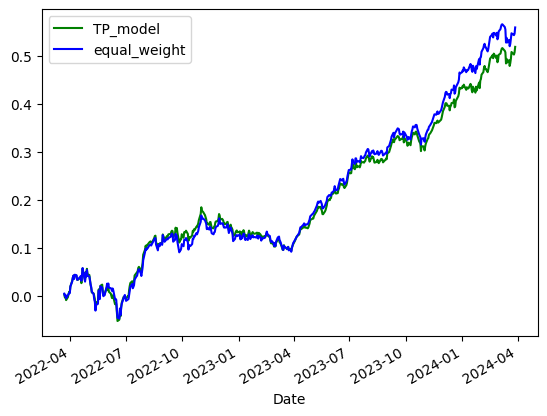

In [ ]:
import matplotlib.pyplot as plt
((data.loc[test_index, :].pct_change().dropna() * test_weights[1:, :]).sum(axis = 1) + 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).cumsum().plot(color = 'green')
(data.loc[test_index, :].pct_change().dropna() * np.ones(test_weights[1:, :].shape) * 1 / 17).sum(axis = 1).cumsum().plot(color = 'blue',)
plt.legend(['TP_model', 'equal_weight'])
plt.show()